## NEURAL NETS ON PYTORCH

* DATASET: **MNIST**
* AUTHOR: *yashlab*

Need measures to determine model performance and chek for overfitting etc.
* Use the concept of a test set. Find out accuracy on unseen data.

In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt

Glance at MNIST dataset:

<img src='FILES/mnist.png'>

In [2]:
from torchvision import datasets, transforms

# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=40, shuffle=True)

In [3]:
dataiter = iter(trainloader) # create an iterator object on trainloader
images, labels = dataiter.next() # perform an iteration 
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
# Function to display an image
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406]) # standard normailised mean for MNIST
        std = np.array([0.229, 0.224, 0.225]) # # standard normailised std for MNIST
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

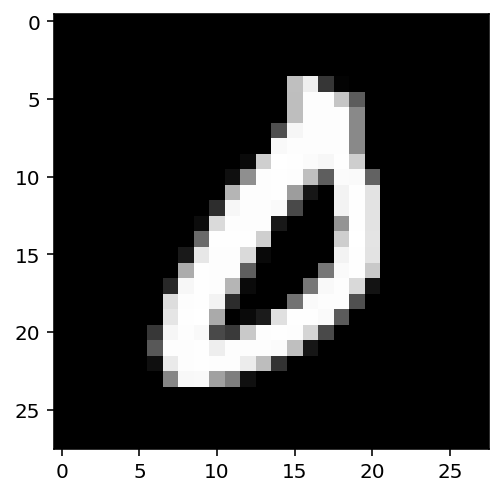

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [6]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax()
)

In [7]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Loss Function
criterion = nn.NLLLoss()

Repeating the same process over a batch from the trainloader

In [8]:
train_losses, test_losses = [], []
epochs = 8
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        # the validation pass and print out the validation accuracy
        testloss=0
        accuracy=0
        with torch.no_grad():
            for img,label in testloader:
                img = img.view(img.shape[0],-1)
                log_ps = model(img)
                testloss  += criterion(log_ps,label)
            
                ps = torch.exp(log_ps)        
                top_p, top_cl = ps.topk(1,dim=1)
                match = top_cl == label.view(*top_cl.shape)
                accuracy += torch.mean(match.type(torch.float64))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(testloss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(testloss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/8..  Training Loss: 1.713..  Test Loss: 1.083..  Test Accuracy: 0.800
Epoch: 2/8..  Training Loss: 0.826..  Test Loss: 0.633..  Test Accuracy: 0.858
Epoch: 3/8..  Training Loss: 0.572..  Test Loss: 0.493..  Test Accuracy: 0.879
Epoch: 4/8..  Training Loss: 0.476..  Test Loss: 0.427..  Test Accuracy: 0.890
Epoch: 5/8..  Training Loss: 0.425..  Test Loss: 0.390..  Test Accuracy: 0.896
Epoch: 6/8..  Training Loss: 0.393..  Test Loss: 0.364..  Test Accuracy: 0.899
Epoch: 7/8..  Training Loss: 0.372..  Test Loss: 0.346..  Test Accuracy: 0.903
Epoch: 8/8..  Training Loss: 0.355..  Test Loss: 0.333..  Test Accuracy: 0.906


In [9]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

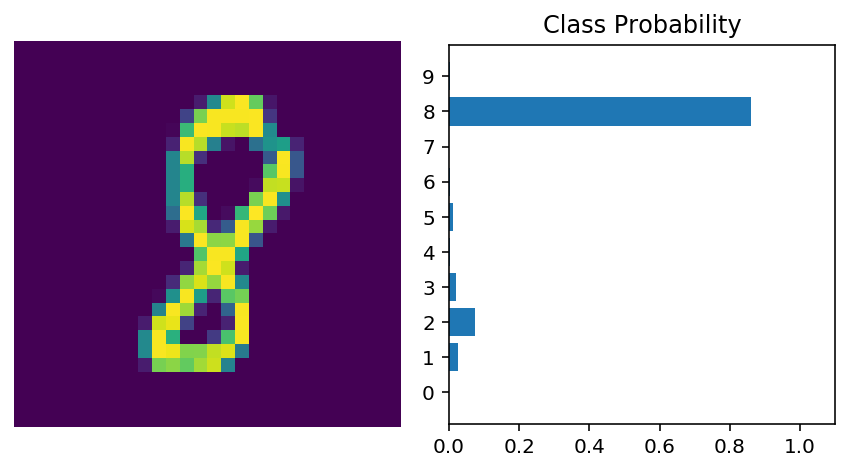

In [10]:
%matplotlib inline

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

> ### **Summary**:
    * Trained a simple neural net with only 1 hidden layer.
    * Understood Forward and Backpropagation
    

> ### **Further Ahead**:
    * Need to understand how our model performs on unseen data
    * Deduce a method to find out accuracy metrics

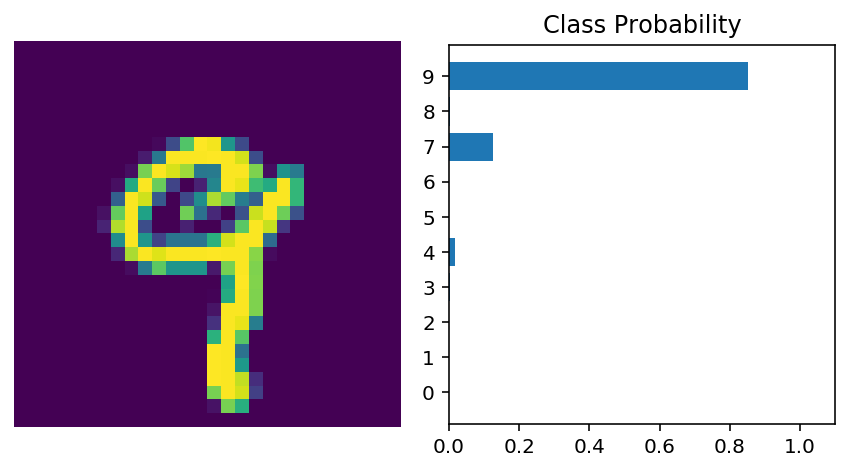

In [11]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='MNIST')

Let's find out Category wise accuracy

In [12]:
classes = [0,1,2,3,4,5,6,7,8,9]
test_loss =0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
batch_size =40
model.eval()
for data,target in testloader:
    data = data.view(data.shape[0],-1)
    
    out = model(data)
    
    _,pred = torch.max(out,dim=1)
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    k=correct
    
    for i in range(testloader.batch_size):
        label = target.data[i]
        
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of     0: 97% (956/980)
Test Accuracy of     1: 97% (1102/1135)
Test Accuracy of     2: 87% (907/1032)
Test Accuracy of     3: 89% (904/1010)
Test Accuracy of     4: 93% (916/982)
Test Accuracy of     5: 82% (740/892)
Test Accuracy of     6: 93% (900/958)
Test Accuracy of     7: 90% (929/1028)
Test Accuracy of     8: 84% (826/974)
Test Accuracy of     9: 87% (882/1009)

Test Accuracy (Overall): 90% (9062/10000)
